In [1]:
# import the necessary packages
from skimage.segmentation import slic,watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.transform import Rotation as R
from sklearn.cluster import KMeans,DBSCAN

import open3d as o3d
import sys

from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# generate 2d cluster points

for now we just do rgb clustering
for further work we can project rgb cloud and sample based on the variance of rgb values

In [3]:
# img_root = "./scene0002_00/every2_replaced_ldr/"
scene_root = "./data/formal_scenes/"
# scene_name = "scene0001_01/"
hdr_fold = "hdr/"
depth_fold = "depth/"
normal_fold = "normal/"
cluster_fold = "newclusters/"

===================scene0001_01===================


0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
101it [00:00, 191.12it/s]

450 centers writen to: ./data/formal_scenes/scene0001_01/newclusters/origfov_101.txt



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
201it [00:01, 197.94it/s]

455 centers writen to: ./data/formal_scenes/scene0001_01/newclusters/origfov_201.txt



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
301it [00:01, 203.60it/s]

439 centers writen to: ./data/formal_scenes/scene0001_01/newclusters/origfov_301.txt



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
401it [00:01, 206.50it/s]

441 centers writen to: ./data/formal_scenes/scene0001_01/newclusters/origfov_401.txt



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
501it [00:02, 206.78it/s]

462 centers writen to: ./data/formal_scenes/scene0001_01/newclusters/origfov_501.txt



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
643it [00:02, 219.66it/s]

454 centers writen to: ./data/formal_scenes/scene0001_01/newclusters/origfov_601.txt

===================scene0704_01===================


FileNotFoundError: [Errno 2] No such file or directory: './data/formal_scenes/scene0704_01/pfm/'

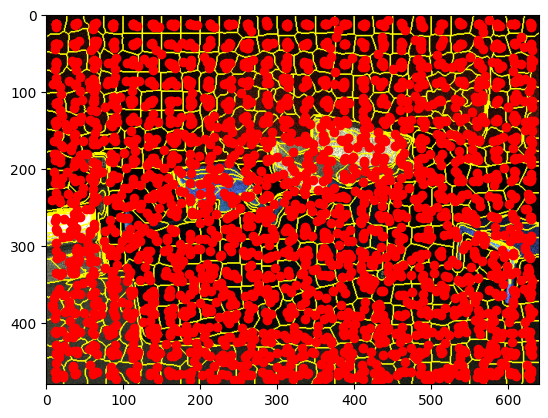

In [9]:
img_start = 100
img_end = 1000
img_step = 100 #!!!!

numSegments = 500 #!!!!

folder = "pfm/" # change to normal or basecolor or ldr for now
# normal_dirs = os.listdir(normal_root+scene_name)
        
mykey = lambda x:int(x.split(".")[0].split("_")[1])

for scene_name in os.listdir(scene_root):
    print("==================="+scene_name+"===================")
    scene_name = scene_name + "/"
    
    img_dirs = sorted(os.listdir(scene_root+scene_name+folder),key=mykey)
    
    img_end = len(img_dirs)
    
    for id_img, img_dir in tqdm(enumerate(img_dirs)):
        
        if id_img < img_start:
            continue
        
        if id_img >= img_end:
            break      
        
        if not id_img % img_step == 0:
            continue
        
        if folder == "pfm/":
            image = cv2.imread(scene_root+scene_name+folder+img_dir, cv2.IMREAD_UNCHANGED)
        else:
            image = img_as_float(io.imread(scene_root+scene_name+folder+img_dir))

        segments = slic(image, n_segments = numSegments, sigma = 3, compactness=1, max_size_factor=1)
        # those look similar share the same envmap, either is really similar or they are robust to different envmaps
        
        numResult = len(set(segments.flatten()))
        centers = np.zeros([numResult,2])
        for s in range(segments.min(), segments.max()+1):
            centers[s-1,:]=np.argwhere(segments==s).mean(axis=0)
        centers = centers.round()
        plt.imshow(mark_boundaries(image, segments))
        
        plt.scatter(centers[:,1],centers[:,0],marker='o',color='r')
        cluster_path = scene_root + scene_name + cluster_fold
        if not os.path.exists(cluster_path):
            os.mkdir(cluster_path)
        output_path = cluster_path+img_dir.split('.')[0]+".txt"
        print(str(centers.shape[0])+" centers writen to: "+output_path+"\n")
        # break
        np.savetxt(output_path,centers,fmt='%d')
    
    # break

# Project the centers and load the result back
Now we use the control points lifted by reduced depth

In [10]:
import numpy as np
import open3d as o3d
import cv2
import os
import sys
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

def gen_local_map_in_world2(depth_img, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=0, normal_img=None):
    # lift by the normal image
    fx = intrinsic[0]
    fy = intrinsic[1]
    cx = intrinsic[2]
    cy = intrinsic[3]

    # local_pts_in_world = np.zeros((depth_img.shape[0] * depth_img.shape[1], 3))
    local_pts_in_world = np.empty((0, 3), float)

    # for i in range(depth_img.shape[0]): # row
    #
    #     for j in range(depth_img.shape[1]): # col
    
    normal_img = normal_img[:,:,[2,1,0]]
    # normal_img[:,:,0] = -normal_img[:,:,0]
    # normal_img[:,:,1] = -normal_img[:,:,1]
    # normal_img[:,:,2] = -normal_img[:,:,2]

    for center_id in range(super_pix_centers.shape[0]):

        i = super_pix_centers[center_id, 0] # row id
        j = super_pix_centers[center_id, 1] # col id

        depth = depth_img[i, j]

        if depth == 0:
            continue

        # print(str(depth))

        u = j # col
        v = i # row ?????????


        z = depth / depth_scale

        x = (u - cx) * z / fx

        y = (v - cy) * z / fy

        one_local_pt = [x, y, z]

        # print(str(x) + ' ' + str(y) + ' ' + str(z))

        one_local_pt = np.array(one_local_pt)
        
        if not (normal_img is None):
            nnorm = np.linalg.norm(normal_img[i,j,:])
            one_local_pt -= normal_img[i,j,:]/nnorm*(lift)
        
        one_local_pt = one_local_pt.reshape((3,1))

        t_c2w_ = t_c2w.reshape((3,1))

        pt_only_rot = np.matmul(R_c2w, one_local_pt)
        one_local_pt_in_world = pt_only_rot + t_c2w_

        one_local_pt_in_world = one_local_pt_in_world.reshape((1,3))
        
        # if not (normal_img is None):
        #     one_local_pt_in_world += normal_img[i,j,:]*(lift)

        # one_local_pt_in_world = one_local_pt_in_world.reshape(3)

        # local_pts_in_world[i*depth_img.shape[1] + j, :] = one_local_pt_in_world
        local_pts_in_world = np.append(local_pts_in_world, one_local_pt_in_world, axis=0)

        # local_pts.append(one_local_pt)


    return local_pts_in_world

def convert_depth_to_pcl(depth_image, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers=None, lift_depth=0.0, pts_per=1):
    
    fx = intrinsic[0]
    fy = intrinsic[1]
    cx = intrinsic[2]
    cy = intrinsic[3]
    
    center_x = cx
    center_y = cy

    constant_x = 1 / fx
    constant_y = 1 / fy

    # pointcloud_xzyrgb_fields = [
    #     PointField(name='x', offset=0, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='y', offset=4, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='z', offset=8, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='rgb', offset=12, datatype=PointField.UINT32, count=1)
    # ]

    vs = np.array(
        [(v - center_x) * constant_x for v in range(0, depth_image.shape[1])])
    us = np.array(
        [(u - center_y) * constant_y for u in range(0, depth_image.shape[0])])

    # Convert depth from mm to m.
    depth_image = depth_image / depth_scale - lift_depth

    x = np.multiply(depth_image, vs)
    y = depth_image * us[:, np.newaxis]

    stacked = np.ma.dstack((x, y, depth_image))
    if not (super_pix_centers is None):
        stacked = stacked[super_pix_centers[:,0],super_pix_centers[:,1]]
    compressed = stacked.compressed()
    
    
    pointcloud = compressed.reshape((int(compressed.shape[0] / 3), 3))

    # pointcloud = np.hstack((pointcloud[:, 0:3],
    #                         pack_bgr(*pointcloud.T[3:6])[:, None]))
    # pointcloud = [[point[0], point[1], point[2], point[3]]
    #               for point in pointcloud]

    # pointcloud = pc2.create_cloud(Header(), pointcloud_xzyrgb_fields,
    #                               pointcloud)
    
    H = np.eye(4,4)
    H[:3,:3] = R_c2w
    H[:3,3] = t_c2w
    
    pt = o3d.geometry.PointCloud()
    pt.points = o3d.utility.Vector3dVector(pointcloud)
    pt = pt.transform(H)
    pointcloud = np.asarray(pt.points)
    
    return pointcloud[::pts_per,:]

def read_depthdata(depth_path):
    # load depth data and convert to 16UC1
    with open(depth_path,'rb') as f:
        data = np.fromfile(f,dtype=np.float32)
        data = data[2:] # try drop first 2
        depth = data.reshape([480,640])
    return depth
# plt.imshow(depth_root)

def visual_pts(pts,color=False,frame=True):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts[:,:3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(pts[:,3:6]/255)
        
    list_visual = [pcd]
    if frame:
        frames = o3d.geometry.TriangleMesh.create_coordinate_frame()
        list_visual.append(frames)
    o3d.visualization.draw_geometries(list_visual)

def normal_transform(normals_c_oneView,R_c2w):
    a,b,c = normals_c_oneView.shape
    for i in range(a):
        for j in range(b):
            xyz = normals_c_oneView[i,j,:]
            xyz = np.matmul(R_c2w,xyz)
            normals_c_oneView[i,j,:] = xyz
    return normals_c_oneView
    
def lookat2quat(lookat_mat):
    origin = lookat_mat[:3]
    lookat_pts = lookat_mat[3:6]
    up_vec = lookat_mat[6:9]

    H = np.identity(4)

    camera_w = (lookat_pts-origin)/np.linalg.norm(lookat_pts-origin)

    camera_up = up_vec - np.dot(up_vec,camera_w)*camera_w
    camera_up = camera_up/np.linalg.norm(camera_up)

    camera_right = np.cross(camera_w,camera_up)
    camera_right = camera_right/np.linalg.norm(camera_right)

    H[:3,3] = origin
    H[:3,0] = camera_right
    H[:3,1] = -camera_up
    H[:3,2] = camera_w

    R_c2w = H[:3,:3]
    quat = R.from_matrix(R_c2w).as_quat()
    quat = np.array([quat[3],quat[0],quat[1],quat[2]]) # scalar first!!!!!
    return np.hstack([quat,origin])

def get_all_uvs(h,w):
    xs = np.array(list(range(0,h,10)))
    ys = np.array(list(range(0,w,10)))
    xxs, yys = np.meshgrid(xs,ys)
    return np.array([xxs.flatten(),yys.flatten()]).T
get_all_uvs(480,640)
## test with rendering poses
# origin = np.array([-1.726888, -0.224992, 1.240625])
# lookat_pts = np.array([-2.1865239144921595, -0.7589694874667879, 1.950274821382076])
# up_vec = np.array([-0.31294764223241284, 0.8451875066551581, 0.4332687985710611])
# lookat_mat = np.hstack([origin,lookat_pts,up_vec])
# lookat2quat(lookat_mat) # # array([-0.2758599 , -0.2628239 ,  0.92005167, -0.09126797, -1.726888  , -0.224992  ,  1.240625  ])

array([[  0,   0],
       [ 10,   0],
       [ 20,   0],
       ...,
       [450, 630],
       [460, 630],
       [470, 630]])

In [23]:
print(sys.path)

scenes_root = "./data/formal_scenes/"
pose_root = "./data/poses_per2frame/every2frame/"
output_root = "./output/lookats_control_point/"

# output_folder = './output_cam_file/'

# scene_names_path = '/storage/user/lhao/hjp/ws_superpixel/haoang_control_pts/scene_names_demo.txt' # !!!!!!!!!!!!!!!!!!!!!!! TO adjust
center_fold = "newclusters/"

depth_fold = "depth/"
normal_fold = "normal/"

depth_scale = 1  # ??????????
# intrinsic = [577.591, 578.73, 318.905, 242.684] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# intrinsic = [222.22, 222.22, 160, 120]
intrinsic = [577.8705679012345,577.8705679012345,320,240]

lift = 0.005 #!!!!!!

TEST_ALL_UVS = False

scene_names = os.listdir(scenes_root)

scene_names = ["scene0001_01"]

# scene_idx = 0
for scene_idx, scene_name in enumerate(scene_names):
    # scene_name = scene_name.rstrip()
    
    scene_path = scenes_root + scene_name

    # img poses
    poses_path = pose_root + scene_name + '.txt'
    # poses_path = 'haoang_process_results/' + scene_name + '.txt'

    # with open(poses_path) as f_poses:
    #     poses = f_poses.readlines()
    poses = np.loadtxt(poses_path)

    output_folder = output_root + scene_name + '/'
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    pts_in_world_all_mulView = np.empty((0, 9), float)
    
    mykey = lambda x:int(x.split(".")[0].split("_")[1])
    
    depth_all_names = sorted(os.listdir(os.path.join(scene_path, depth_fold)),key=mykey)
    center_all_names = sorted(os.listdir(os.path.join(scene_path, center_fold)),key=mykey)
    normal_all_names = sorted(os.listdir(os.path.join(scene_path, normal_fold)),key=mykey)

    # pts_in_world_all_mulView = np.ones((len(depth_all_names),3),float)
    pts_all = np.empty((0,3))

    for center_name in center_all_names:

        pose_idx = int(center_name.split(".")[0].split("_")[1])

        depth_name = depth_all_names[pose_idx-1]

        normal_name = normal_all_names[pose_idx-1]

        # break
        depth_path = os.path.join(os.path.join(scene_path, depth_fold, depth_name))
        
        center_path = os.path.join(os.path.join(scene_path, center_fold, center_name))
        
        normal_path = os.path.join(os.path.join(scene_path, normal_fold, normal_name))
        
        depth_all = read_depthdata(depth_path)
        
        # pose = poses[pose_idx].rstrip()
        # pose = pose.split(' ')
        # pose = list(map(float, pose))

        pose = poses[pose_idx-1,:]
        print("center:{} with pose:{}".format(str(center_name),str(pose)))
        
        if TEST_ALL_UVS:
            # if (pose_idx != 10) and (pose_idx!=14): # !!!!
            #     continue
            print(pose)

        q_c2w = [pose[1], pose[2], pose[3], pose[0]]
        q_c2w = np.array(q_c2w)
        # q_c2w = q_c2w.reshape((1, 4))
        r_c2w = R.from_quat(q_c2w)
        R_c2w = r_c2w.as_matrix()

        t_c2w = pose[4:7]
        t_c2w = np.array(t_c2w)
        
        normals_c_oneView = plt.imread(normal_path)
        # break
        super_pix_centers = np.loadtxt(center_path,dtype=np.int32)
        # break
        
        if TEST_ALL_UVS:
            pts_oneView = convert_depth_to_pcl(depth_all,intrinsic, depth_scale, R_c2w, t_c2w)
            pts_all = np.append(pts_all,pts_oneView,axis=0)
        
        # origin_in_world_oneView = gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=0, normal_img=normals_c_oneView)
        origin_in_world_oneView = convert_depth_to_pcl(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift_depth=lift)
        
        # lookat_in_world_oneView =  gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=2*lift, normal_img=normals_c_oneView)
        lookat_in_world_oneView =  convert_depth_to_pcl(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift_depth=3*lift)
        
        up_vectors_oneView = np.zeros_like(lookat_in_world_oneView)
        up_vectors_oneView[:,2] = 1

        pts_in_world_all_oneView = np.hstack([origin_in_world_oneView, lookat_in_world_oneView, up_vectors_oneView])

        pts_in_world_all_mulView = np.append(pts_in_world_all_mulView, pts_in_world_all_oneView, axis=0)

        print('Complete pose ' + str(pose_idx) + '/' + str(len(depth_all_names)) + ', scene ' + str(scene_idx + 1) + '/' + str(len(scene_names)))

        # pose_idx = pose_idx + 1
        # break
    output_path_all_mulView = output_folder + scene_name + '_control_cam' +'.txt'
    # break
    if TEST_ALL_UVS:
        np.savetxt(output_folder + scene_name + 'test_all_uvs' +'.txt',pts_all, header='#x y z')
        break
    
    output_quats_mulView = np.zeros([len(pts_in_world_all_mulView),7])
    for id,lookat_mat in enumerate(pts_in_world_all_mulView):
        output_quats_mulView[id,:] = lookat2quat(lookat_mat)
    np.savetxt(output_folder + scene_name + '_control_cam_pose' +'.txt',output_quats_mulView, header='# qw qx qy qz x y z') #!!!!
    
    with open(output_path_all_mulView, 'w') as f_output_path_all_mulView:
        num = pts_in_world_all_mulView.shape[0]
        f_output_path_all_mulView.write( str(num) + '\n')
        for i in range(num):
            # if not i%10==0:
            #     continue
            f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][0]) + ' ' + str(pts_in_world_all_mulView[i][1]) + ' ' + str(
                pts_in_world_all_mulView[i][2]) + '\n')
            f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][3]) + ' ' + str(pts_in_world_all_mulView[i][4]) + ' ' + str(
                pts_in_world_all_mulView[i][5]) + '\n')
            f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][6]) + ' ' + str(pts_in_world_all_mulView[i][7]) + ' ' + str(
                pts_in_world_all_mulView[i][8]) + '\n')
    
    # np.savetxt(output_path_all_mulView, pts_in_world_all_mulView)
    # break
    print('Comelete Scene ' + str(scene_idx + 1) + '/' + str(len(scene_names)) )
    print('===================================================')


['/storage/user/lhao/hjp/ws_superpixel', '/usr/wiss/lhao/anaconda3/envs/superpixel/lib/python38.zip', '/usr/wiss/lhao/anaconda3/envs/superpixel/lib/python3.8', '/usr/wiss/lhao/anaconda3/envs/superpixel/lib/python3.8/lib-dynload', '', '/usr/wiss/lhao/.local/lib/python3.8/site-packages', '/usr/wiss/lhao/Hierarchical-Localization', '/usr/wiss/lhao/.local/lib/python3.8/site-packages/pymesh2-0.3-py3.8-linux-x86_64.egg', '/usr/wiss/lhao/anaconda3/envs/superpixel/lib/python3.8/site-packages']
center:origfov_1.txt with pose:[ 0.112101  0.965581 -0.073195  0.223002 -1.171897  0.539241  0.613169]
Complete pose 1/643, scene 1/1
center:origfov_101.txt with pose:[ 0.064763  0.333364 -0.151696  0.928258 -0.917399  0.441786  0.398841]
Complete pose 101/643, scene 1/1
center:origfov_201.txt with pose:[-0.016075 -0.317592 -0.160529  0.934402 -0.161567  0.257666  0.557867]
Complete pose 201/643, scene 1/1
center:origfov_301.txt with pose:[ 0.22335   0.93478  -0.083199  0.263399  0.269703  0.300717 -0.37

now we can visualize our result, green for lookat points and red for camera origins

In [22]:
pt_origins = o3d.geometry.PointCloud()
pt_origins.points = o3d.utility.Vector3dVector(pts_in_world_all_mulView[:,:3])
pt_origins.paint_uniform_color(np.array([1,0,0]))

pt_lookats = o3d.geometry.PointCloud()
pt_lookats.points = o3d.utility.Vector3dVector(pts_in_world_all_mulView[:,3:6])
pt_lookats.paint_uniform_color(np.array([0,1,0]))

pt_cams = o3d.geometry.PointCloud()
pt_cams.points = o3d.utility.Vector3dVector(poses[list(range(img_start,img_end,img_step)),4:7])
pt_cams.paint_uniform_color(np.array([0,0,1]))

pt_all = o3d.geometry.PointCloud()
pt_all.points = o3d.utility.Vector3dVector(pts_all)
pt_all.paint_uniform_color(np.array([0.5,0.5,0.5]))

frame = o3d.geometry.TriangleMesh.create_coordinate_frame()

o3d.visualization.draw_geometries([pt_lookats,pt_origins,pt_cams,frame],point_show_normal=True)

# Devel and Debug

## Debug for normal direction

In [17]:
# single frame checking

R_c2w = np.eye(3,3)
t_c2w = np.array([0,0,0])

normals_c_oneView = plt.imread(normal_path)
print(normal_path)

depth_all = read_depthdata(depth_path)
print(depth_path)

lift = 0.005

# origin_in_world_oneView = gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=0, normal_img=normals_c_oneView)

origin_in_world_oneView = convert_depth_to_pcl(depth_all,intrinsic,depth_scale,R_c2w,t_c2w,super_pix_centers=super_pix_centers, lift_depth=lift)

# lookat_in_world_oneView =  gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=2*lift, normal_img=normals_c_oneView)

lookat_in_world_oneView = convert_depth_to_pcl(depth_all,intrinsic,depth_scale,R_c2w,t_c2w,super_pix_centers=super_pix_centers,lift_depth=3*lift)

pt_all = convert_depth_to_pcl(depth_all,intrinsic, depth_scale, R_c2w, t_c2w)

pt_origins = o3d.geometry.PointCloud()
pt_origins.points = o3d.utility.Vector3dVector(origin_in_world_oneView)
pt_origins.paint_uniform_color(np.array([1,0,0]))

pt_lookats = o3d.geometry.PointCloud()
pt_lookats.points = o3d.utility.Vector3dVector(lookat_in_world_oneView)
pt_lookats.paint_uniform_color(np.array([0,1,0]))

pt_cams = o3d.geometry.PointCloud()
pt_cams.points = o3d.utility.Vector3dVector(poses[list(range(img_start,img_end,img_step)),4:7])
pt_cams.paint_uniform_color(np.array([0,0,1]))

frame = o3d.geometry.TriangleMesh.create_coordinate_frame()

o3d.visualization.draw_geometries([pt_lookats,pt_origins, pt_cams,frame],point_show_normal=True)

./data/formal_scenes/scene0001_01/normal/origfovnormal_601.png
./data/formal_scenes/scene0001_01/depth/origfovdepth_601.dat


In [522]:
stacked[super_pix_centers[:,0],super_pix_centers[:,1]].shape

(555, 3)

In [504]:
visual_pts(lookat_in_world_oneView-origin_in_world_oneView)

In [503]:
np.savetxt("./origin.txt",origin_in_world_oneView)
np.savetxt("./lookat.txt",lookat_in_world_oneView)

In [498]:
normals_c_oneView[0,0,:]

array([0.9764706 , 0.45490196, 0.6431373 ], dtype=float32)

In [500]:
cv2.imread(normal_path)/255.0

array([[[0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        ...,
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ]],

       [[0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        ...,
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ]],

       [[0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        ...,
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ]],

       ...,

       [[0.70588235, 0.95294118, 0.47843137],
        [0.70588235, 0.95294118, 0.47843137],
        [0.70588235, 0

In [484]:
# 518 544 relative pose
id0 = 518
id1 = 544

pose0 = poses[id0-1,:]
pose1 = poses[id1-1,:]

q_c2w0 = [pose0[1], pose0[2], pose0[3], pose0[0]]
q_c2w0 = np.array(q_c2w0)
# q_c2w = q_c2w.reshape((1, 4))
r_c2w0 = R.from_quat(q_c2w0)
R_c2w0 = r_c2w0.as_matrix()

t_c2w0 = pose0[4:7]
t_c2w0 = np.array(t_c2w0)

H0 = np.eye(4,4)
H0[:3,:3] = R_c2w0
H0[:3,3] = t_c2w0

q_c2w1 = [pose1[1], pose1[2], pose1[3], pose1[0]]
q_c2w1 = np.array(q_c2w1)
# q_c2w = q_c2w.reshape((1, 4))
r_c2w1 = R.from_quat(q_c2w1)
R_c2w1 = r_c2w1.as_matrix()

t_c2w1 = pose1[4:7]
t_c2w1 = np.array(t_c2w1)

H1 = np.eye(4,4)
H1[:3,:3] = R_c2w1
H1[:3,3] = t_c2w1

img_norm0 = plt.imread("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0001_01/normal/origfovnormal_518.png")
img_norm1 = plt.imread("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0001_01/normal/origfovnormal_544.png")

norm0 = img_norm0[0,0,:]
norm0 = norm0/np.linalg.norm(norm0)
norm1 = img_norm1[0,0,:]
norm1 = norm1/np.linalg.norm(norm1)

print(norm0)
print(norm1)

Rt = np.matmul(R_c2w1.T,R_c2w0)

print(np.matmul(Rt,norm0))


[0.7182868  0.27056545 0.6409824 ]
[0.54478073 0.19583622 0.81539077]
[0.87412507 0.45513754 0.1695736 ]


In [485]:
print(np.matmul(R_c2w0,norm0))
print(np.matmul(R_c2w1,norm1))

[-0.66267637 -0.41865606  0.62095665]
[ 0.06491376 -0.59317218  0.80245432]


In [483]:
print(img_norm0[479,639,:])
print(img_norm1[479,639,:])

[0.5529412  0.9529412  0.69411767]
[0.5254902  0.9098039  0.78431374]


In [478]:
norm0

array([0.8745098 , 0.32941177, 0.78039217], dtype=float32)

In [479]:
norm1

array([0.6       , 0.21568628, 0.8980392 ], dtype=float32)

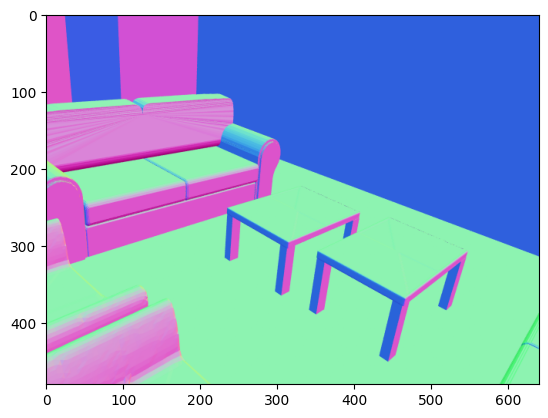

In [475]:
plt.imshow(img_norm0)

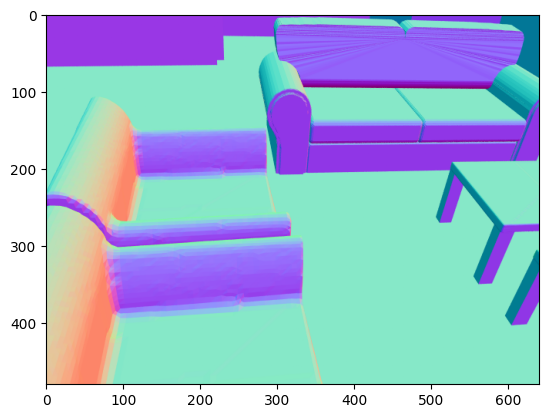

In [476]:
plt.imshow(img_norm1)

In [23]:
test_xyz = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/lookats_control_point/scene0001_01/scene0001_01test_xyz.txt")
control_poses = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/lookats_control_point/scene0001_01/scene0001_01_control_cam_pose.txt")
# visual_pts(test_xyz[:,4:],color=False)
# test_xyz = test_xyz[:,4:]
# visual_pts(test_xyz,color=False)
# visual_pts(pts_in_world_all_mulView[:,:3],color=False)

In [41]:
# output_quats_mulView = np.zeros([len(pts_in_world_all_mulView),7])
# for id,lookat_mat in enumerate(pts_in_world_all_mulView):
#     output_quats_mulView[id,:] = lookat2quat(lookat_mat)
# np.savetxt(output_folder + scene_name + '_control_cam_pose' +'.txt',output_quats_mulView, header='qw qx qy qz x y z')

## Get the lookats back to quaternionxyz format


In [27]:
len(pts_in_world_all_mulView)

1269

In [24]:
lookat_mat = pts_in_world_all_mulView[0]
origin = lookat_mat[:3]
lookat_pts = lookat_mat[3:6]
up_vec = lookat_mat[6:9]

H = np.identity(4)

camera_w = (lookat_pts-origin)/np.linalg.norm(lookat_pts-origin)

camera_up = up_vec - np.dot(up_vec,camera_w)*camera_w
camera_up = camera_up/np.linalg.norm(camera_up)

camera_right = np.cross(camera_w,camera_up)
camera_right = camera_right/np.linalg.norm(camera_right)

H[:3,3] = origin
H[:3,0] = camera_right
H[:3,1] = -camera_up
H[:3,2] = camera_w

R_c2w = H[:3,:3]
quat = R.from_matrix(R_c2w).as_quat()
np.hstack([quat,origin])

array([-0.2758599 , -0.2628239 ,  0.92005167, -0.09126797, -1.726888  ,
       -0.224992  ,  1.240625  ])

In [3]:
# check the direction of the normals is alon the optical axis of the camera

# np.savetxt("lift.txt", pts_in_world_all_oneView_lifted)
# np.savetxt("nolift.txt", pts_in_world_all_oneView)

In [13]:
# plt.imshow(normals_c_oneView)
# a,b,c = normals_c_oneView.shape
# for i in range(a):
#     for j in range(b):
#         xyz = normals_c_oneView[i,j,:]
#         xyz = np.matmul(R_c2w,xyz)
#         normals_c_oneView[i,j,:] = xyz
# plt.imshow(normals_c_oneView)

In [14]:
xyz = normals_c_oneView[100,600,:]
xyz.dot(np.array([0,0,1]))

0.729411780834198

In [7]:
visual_pts(pts_in_world_all_mulView, color=False)

## Load trajectory

In [20]:
# traj_path = './sparse30/scene0002_00gt.txt'
# # lookat_path = './sparse30/scene0002_00lookat.txt'
# r = np.loadtxt(traj_path)
# rsparse = r[0:150:30]
# np.savetxt('./sparse30/sparse30.txt',rsparse)

In [39]:
# traj_path = './sparse30/scene0001_00gt.txt'
# # lookat_path = './sparse30/scene0002_00lookat.txt'
# r = np.loadtxt(traj_path)
# rsparse = r[0::100]
# np.savetxt('./sparse30/scene0001_00.txt',rsparse)
# rsparse.shape

(9, 7)

In [31]:
traj_path = "./sparse30/scene0002_00.txt"
traj = np.loadtxt(traj_path)
traj

array([[-1.340000e-04, -2.479700e-01, -2.449100e-01,  9.372990e-01,
         1.424611e+00,  7.543500e-02, -4.338040e-01],
       [-5.742100e-02, -3.586660e-01, -2.337940e-01,  9.018880e-01,
         1.389048e+00,  7.894000e-02, -4.764700e-02],
       [-1.910430e-01, -5.660010e-01, -1.943450e-01,  7.780590e-01,
         1.311833e+00,  1.101250e-01,  3.972050e-01],
       [ 1.914100e-01,  7.866610e-01,  8.648400e-02, -5.805580e-01,
         1.145395e+00,  1.473280e-01,  6.533280e-01],
       [ 2.717670e-01,  9.006210e-01, -2.166000e-03, -3.391450e-01,
         8.602110e-01,  1.778700e-01,  4.751650e-01]])

## Load pfm

In [20]:
ans = cv2.imread("/storage/user/lhao/hjp/ws_superpixel/formal_scenes/scene0001_01/pfm/origfov_1.pfm",cv2.IMREAD_UNCHANGED)
cv2.imshow('test',ans)
cv2.waitKey(0)
cv2.destroyAllWindows() # press q
# ans[ans.nonzero()]

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread

# FOV

In [ ]:
intrinsic = [2*222.22, 2*222.22, 640, 480]

In [7]:
2*np.arctan(640/2/444.44)/np.pi*180

71.50831788654655

In [10]:
2*np.arctan(1296/2/1170.1879)/np.pi*180

57.95161640727124

In [11]:
2*np.arctan(320/2/222.2)/np.pi*180

71.51320860769698

In [19]:
640/1296*1170.1879

577.8705679012345

In [20]:
2*np.arctan(640/2/577.8705)/np.pi*180

57.95162211365359

In [2]:
2*np.arctan(480/2/577.8705)/np.pi*180

45.10797942609714

In [ ]:
import math
class Spherical(object):
  '''球坐标系'''
  def __init__(self, radial = 1.0, polar = 0.0, azimuthal = 0.0):
    self.radial = radial
    self.polar = polar
    self.azimuthal = azimuthal
  def toCartesian(self):
    '''转直角坐标系'''
    r = math.sin(self.azimuthal) * self.radial
    x = math.cos(self.polar) * r
    y = math.sin(self.polar) * r
    z = math.cos(self.azimuthal) * self.radial
    return x, y, z
def splot(limit):
  s = Spherical()
  n = int(math.ceil(math.sqrt((limit - 2) / 4)))
  azimuthal = 0.5 * math.pi / n
  for a in range(-n, n + 1):
    s.polar = 0
    size = (n - abs(a)) * 4 or 1
    polar = 2 * math.pi / size
    for i in range(size):
      yield s.toCartesian()
      s.polar += polar
    s.azimuthal += azimuthal
for point in splot(input('')):
  print("%f %f %f" % point)